In [1]:
%cd ..
%reload_ext autoreload
%autoreload 2

D:\ownCloud\Uni\Semester Ma 5\3D Scanning & Motion Capture (IN2354)\Project\3D-FaceReconstruction


In [217]:
import numpy as np
import trimesh
import dlib
import cv2
import pyrender
import matplotlib.pyplot as plt

from scipy import optimize
from pyquaternion import Quaternion

from face_reconstruction.landmarks import load_bfm_landmarks, detect_landmarks
from face_reconstruction.model import BaselFaceModel

from env import DATA_PATH, MODELS_PATH

# 1. Face Model

In [73]:
bfm = BaselFaceModel.from_h5("model2019_face12.h5")
bfm_landmarks = load_bfm_landmarks("model2019_face12_landmarks")
bfm_landmarks_indices = list(bfm_landmarks.values())

In [4]:
n_shape_coefficients = bfm.get_n_shape_coefficients()
n_expression_coefficients = bfm.get_n_expression_coefficients()
n_color_coefficients = bfm.get_n_color_coefficients()

In [5]:
shape_coefficients = [0 for _ in range(n_shape_coefficients)]
expression_coefficients = [0 for _ in range(n_expression_coefficients)]
color_coefficients = [0 for _ in range(n_color_coefficients)]

In [6]:
face_mesh = bfm.draw_sample(shape_coefficients, expression_coefficients, color_coefficients)
face_trimesh = bfm.convert_to_trimesh(face_mesh)

In [7]:
reconstructed = bfm.shape_model.get_mean() + bfm.expression_model.get_mean()
reconstructed = reconstructed.reshape((-1, 3))

# 2. Input image

In [167]:
img_path = f"{DATA_PATH}/Keypoint Detection/trump.jpg"
img = cv2.imread(img_path)

In [9]:
landmarks_img = detect_landmarks(img)

In [10]:
img_width = img.shape[1]
img_height = img.shape[0]

In [11]:
perspective_camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
projection_matrix = perspective_camera.get_projection_matrix(width=img_width, height=img_height)
projection_matrix

array([[ 2.19550972,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.73205081,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.        , -0.1       ],
       [ 0.        ,  0.        , -1.        ,  0.        ]])

In [151]:
initial_camera_pose = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -602.61285643], [0, 0, 0, 1]]) # position camera just in front of face

In [141]:
def project_points(projection_matrix, camera_pose, points):
    if not isinstance(points, np.ndarray):
        points = np.array(points)
    if points.shape[1] == 3:
        points = np.hstack((points, np.ones((points.shape[0], 1), dtype=points.dtype)))
    points_projected = projection_matrix @ camera_pose @ points.T
    points_screen = points_projected / points_projected[2,:]
    points_screen[1, :] = -points_screen[1, :]
    points_pixels = (points_screen + 1) / 2 * np.array([[img_width], [img_height], [0], [0]])
    points_pixels = points_pixels[:2,:].T
#     points_pixels = np.rint(points_pixels).astype(int)
    return points_pixels

In [14]:
points = np.zeros((100, 4))
points[:25] = np.array([[i, 5, 0, 1] for i in range(25)])
points[25:50] = np.array([[0, 5 + i, 0, 1] for i in range(25)])
points[50:75] = np.array([[0 + i, 5 + 25, 0, 1] for i in range(25)])
points[75:] = np.array([[0 + 25, 5 + i, 0, 1] for i in range(25)])

In [15]:
landmark_points = np.array(face_mesh.vertices)[list(bfm_landmarks.values())]

In [154]:
points_pixels = project_points(projection_matrix, initial_camera_pose, landmark_points)

In [312]:
points_pixels = project_points(face_mesh.vertices)

In [293]:
points_pixels = project_points(points)

In [258]:
def draw_pixels_to_image(img, pixels, color=1):
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    for pixel in pixels:
    
        x = round(pixel[0])
        y = round(pixel[1])
        if x >= 0 and x < img_width and y >= 0 and y < img_height:
            img[y, x] = color

In [157]:
test_img = np.zeros((img_height, img_width))
for pixel in points_pixels:
    
    x = round(pixel[0])
    y = round(pixel[1])
    if x >= 0 and x < img_width and y >= 0 and y < img_height:
        test_img[y, x] = 1
        
for pixel in landmarks_img:
    
    x = round(pixel[0])
    y = round(pixel[1])
    if x >= 0 and x < img_width and y >= 0 and y < img_height:
        test_img[y, x] = 1

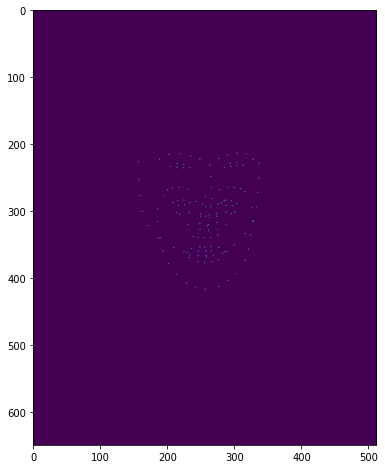

In [158]:
plt.figure(figsize=(12, 8))
plt.imshow(test_img)

In [205]:
list(Quaternion(matrix=initial_camera_pose))

[1.0, 0.0, 0.0, 0.0]

In [658]:
n_params_shape = 20
n_params_expression = 0

In [659]:
class OptimizationParameters:
    
    def __init__(self, shape_coefficients, expression_coefficients, camera_pose):
        self.shape_coefficients = np.hstack([shape_coefficients[:n_params_shape], np.zeros((n_shape_coefficients - n_params_shape))])
        self.expression_coefficients = np.hstack([expression_coefficients[:n_params_expression], np.zeros((n_expression_coefficients - n_params_expression))])
        self.camera_pose = camera_pose
        
        lower_bounds = []
        lower_bounds.extend([-float('inf') for _ in range(n_params_shape)])
        lower_bounds.extend([-float('inf') for _ in range(n_params_expression)])
        lower_bounds.extend([-1, -1, -1, -1])
        self.lower_bounds = np.array(lower_bounds)
        
        upper_bounds = []
        upper_bounds.extend([float('inf') for _ in range(n_params_shape)])
        upper_bounds.extend([float('inf') for _ in range(n_params_expression)])
        upper_bounds.extend([1, 1, 1, 1])
        self.upper_bounds = np.array(upper_bounds)
        
    @staticmethod
    def from_theta(theta):
        shape_coefficients = theta[:n_params_shape] * 10000
        expression_coefficients = theta[n_params_shape:n_params_shape + n_params_expression]
        i = n_params_shape + n_params_expression
#         i = 0
#         shape_coefficients = None
#         expression_coefficients = None
        
        q = Quaternion(*theta[i:i+4]).unit # Important that we only allow unit quaternions
        camera_pose = q.transformation_matrix
        camera_pose[:3, 3] = theta[i+4:i+7]
#         camera_pose = initial_camera_pose
        
#         camera_pose = np.vstack([theta[i:i+4], theta[i+4:i+8], theta[i+8: i+12], [0, 0, 0, 1]])
        return OptimizationParameters(
            shape_coefficients=shape_coefficients,
            expression_coefficients=expression_coefficients,
            camera_pose=camera_pose)
    
    def to_theta(self):
        theta = []
        theta.extend(self.shape_coefficients[:n_params_shape])
        theta.extend(self.expression_coefficients[:n_params_expression])
        q = Quaternion(matrix=self.camera_pose)
        theta.extend(q)
        theta.extend(self.camera_pose[:3, 3])

        return np.array(theta)
        

In [660]:
residuals_before = None
def loss(theta, *args, **kwargs):
    # global residuals_before
    parameters = OptimizationParameters.from_theta(theta)
    # print(parameters.camera_pose)
    # print(parameters.shape_coefficients)
    face_mesh = bfm.draw_sample(
        shape_coefficients=parameters.shape_coefficients, 
        expression_coefficients=parameters.expression_coefficients, 
        color_coefficients=[0 for _ in range(n_color_coefficients)])
    landmark_points = np.array(face_mesh.vertices)[bfm_landmarks_indices]
    landmark_pixels = project_points(projection_matrix, parameters.camera_pose, landmark_points)
    residuals = landmark_pixels - landmarks_img
    # residuals = residuals.reshape(-1)
    residuals = np.linalg.norm(residuals, axis=1)
    # if residuals_before is not None:
     #   print(residuals - residuals_before)
    #residuals_before = residuals
    return residuals

In [661]:
params = OptimizationParameters(
    [0 for _ in range(n_shape_coefficients)],
    [0 for _ in range(n_expression_coefficients)],
    np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -300], [0, 0, 0, 1]])
)

In [662]:
assert all(OptimizationParameters.from_theta(params.to_theta()).to_theta() == params.to_theta()), "OptimizationParameters is ill-defined"

In [663]:
sum([x ** 2 for x in loss(params.to_theta())])

656125.2666838084

In [664]:
params.to_theta()

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    1.,    0.,    0.,    0.,    0.,    0., -300.])

In [665]:
result = optimize.least_squares(loss, params.to_theta(), max_nfev=100, gtol=1e-15)

In [666]:
result

 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        cost: 564.2934595168099
         fun: array([ 4.4530121 ,  1.99213693,  3.91572549,  1.51025987,  0.80862594,
        4.79162738,  1.56863485,  1.6358172 ,  5.44117608,  4.16537106,
        4.30147089,  3.51138553,  3.84728563,  3.14191079,  2.85912813,
        5.12185858,  3.57982444,  2.74669511,  1.61847838,  6.93504868,
       12.29000286, 11.38160285,  8.83412636,  7.26823825,  2.69839591,
        3.25669795,  6.97327178,  2.09480404,  1.04795868,  1.69644536,
        3.29803798,  1.7413523 ,  1.46065324,  3.17135779,  3.54598555,
        2.05930669,  4.23353071,  3.85075753,  3.28868333,  2.11722523,
        4.58589335,  3.74972427,  1.13022887,  1.18625468,  3.18388939,
        2.3721845 ,  3.60928389,  4.62472767,  2.13539208,  2.59272858,
        3.37859202,  2.28191677,  1.47200756,  1.39501058,  1.34230708,
        2.11082792,  1.85

In [667]:
result.x

array([-2.08578711e-05, -3.52682680e-04,  2.78740075e-04,  4.45357381e-04,
       -2.27085135e-04, -7.65716511e-04, -1.29050646e-04, -4.87054920e-05,
       -2.43661941e-04,  3.90175702e-04, -9.78385252e-05, -3.19339212e-04,
       -1.37953925e-04,  9.35234682e-05, -3.52457418e-04,  3.35482384e-04,
       -4.22496944e-05, -2.56005703e-04,  5.22392015e-04,  5.59252097e-04,
       -1.02504951e+03, -3.01576856e+02, -9.38144201e+01,  4.51011170e+00,
       -1.40386205e+01,  9.13845759e+01, -5.07230281e+02])

In [668]:
params = OptimizationParameters.from_theta(result.x)

In [669]:
face_mesh = bfm.draw_sample(
        shape_coefficients=params.shape_coefficients, 
        expression_coefficients=params.expression_coefficients, 
        color_coefficients=[0 for _ in range(n_color_coefficients)])
face_pixels = project_points(projection_matrix, params.camera_pose, face_mesh.vertices)

In [674]:
img = cv2.imread(img_path)

In [671]:
img = np.zeros((img.shape[0], img.shape[1]))

In [675]:
draw_pixels_to_image(img, face_pixels)
draw_pixels_to_image(img, landmarks_img, color=1)

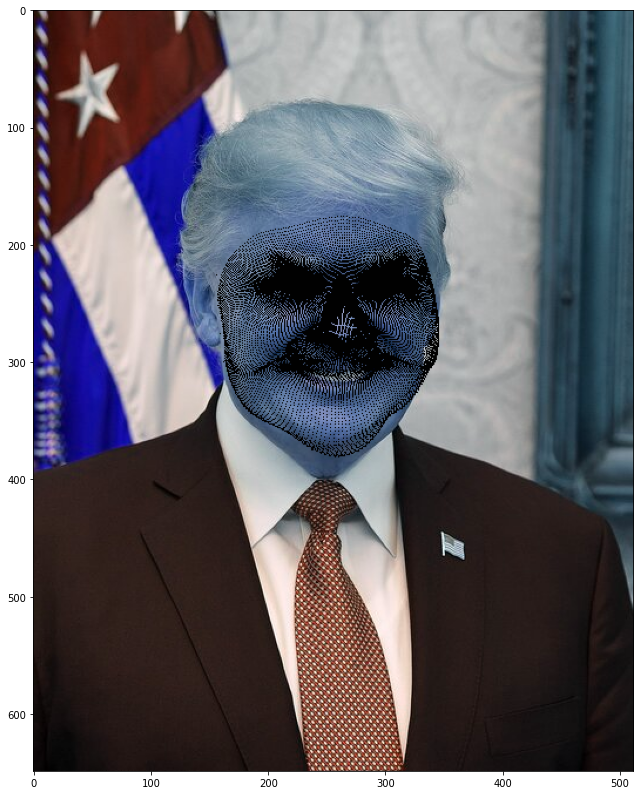

In [676]:
plt.figure(figsize=(20, 14))
plt.imshow(img)

In [681]:
perspective_camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=img.shape[1] / img.shape[0])
directional_light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=2.0)

In [682]:
face_trimesh = bfm.convert_to_trimesh(face_mesh)

In [683]:
scene = pyrender.Scene()
scene.add(pyrender.Mesh.from_trimesh(face_trimesh))
scene.add(perspective_camera, pose=params.camera_pose)
scene.add(directional_light)

In [684]:
pyrender.Viewer(scene, use_raymond_lighting=True)

Viewer(width=640, height=480)